In [134]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [135]:
import scipy
from scipy.stats import norm

In [136]:
stock='AXISBANK.NS'
data = yf.download(stock,'2005-01-01','2023-05-05')

[*********************100%***********************]  1 of 1 completed


In [137]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-01-03,37.000000,38.200001,37.000000,38.040001,32.853146,1421010
2005-01-04,38.220001,38.400002,37.400002,37.939999,32.766777,1115825
2005-01-05,37.990002,37.990002,35.509998,36.849998,31.825399,1163085
2005-01-06,36.820000,38.000000,35.400002,37.029999,31.980860,1192610
2005-01-07,36.130001,38.380001,36.130001,38.020000,32.835873,1530260
...,...,...,...,...,...,...
2023-04-27,888.000000,890.000000,877.500000,881.400024,879.590515,15992383
2023-04-28,885.099976,890.049988,853.650024,860.000000,858.234375,23004117
2023-05-02,870.000000,876.400024,864.250000,870.650024,868.862549,12947953


In [138]:
# data = data[:4000]

In [139]:
returns = np.diff(data['Adj Close'])
returns

array([ -0.08636856,  -0.94137764,   0.15546036, ...,  10.62817383,
       -10.77783203,   6.08746338])

In [140]:
data.shape,returns.shape

((4525, 6), (4524,))

In [141]:
returns.shape

(4524,)

In [142]:
np.sum(returns)

831.319034576416

In [143]:
data['Adj Close']

Date
2005-01-03     32.853146
2005-01-04     32.766777
2005-01-05     31.825399
2005-01-06     31.980860
2005-01-07     32.835873
                 ...    
2023-04-27    879.590515
2023-04-28    858.234375
2023-05-02    868.862549
2023-05-03    858.084717
2023-05-04    864.172180
Name: Adj Close, Length: 4525, dtype: float64

In [144]:
mean = np.mean(returns)
std_dev = np.std(returns)
mean,std_dev

(0.18375752311591867, 8.991497710511563)

In [145]:
pip install KDEpy

In [146]:
import KDEpy

In [147]:
np.array(returns)

array([ -0.08636856,  -0.94137764,   0.15546036, ...,  10.62817383,
       -10.77783203,   6.08746338])

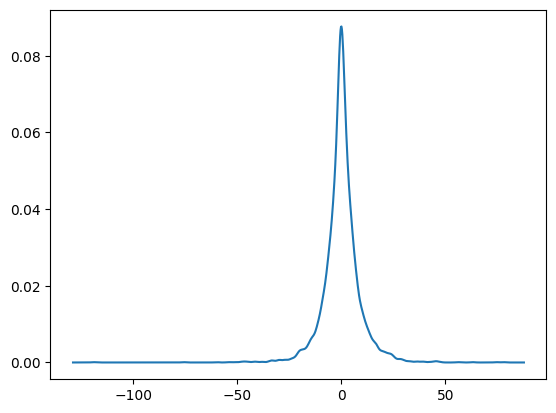

In [148]:
from KDEpy import FFTKDE
import matplotlib.pyplot as plt
x, y = FFTKDE(kernel="gaussian",bw = "silverman").fit(np.array(returns)).evaluate()
plt.plot(x, y)



In [149]:
np.array(data['Adj Close'])

array([ 32.8531456 ,  32.76677704,  31.8253994 , ..., 868.86254883,
       858.0847168 , 864.17218018])

In [150]:
y


array([2.22044605e-16, 2.22044605e-16, 2.22044605e-16, ...,
       2.22044605e-16, 2.22044605e-16, 2.22044605e-16])

In [151]:
np.sum(y)

4.721855769986712

In [152]:
np.sort(np.array(returns))

array([-119.07342529,  -75.82830811,  -59.98504639, ...,   63.17367554,
         74.39697266,   77.87481689])

In [153]:
import torch
import torch.nn as nn


In [154]:
class QuantileLoss(nn.Module):
    def __init__(self, quantile):
        super(QuantileLoss, self).__init__()
        self.quantile = quantile

    def forward(self, predictions, targets):
        errors = targets - predictions
        quantile_loss = torch.max((self.quantile - 1) * errors, self.quantile * errors)
        return quantile_loss.mean()

In [155]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.hidden_layer = nn.Linear(input_size, hidden_size,dtype=torch.float64)
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(hidden_size, output_size,dtype=torch.float64)

    def forward(self, x):
        x = self.hidden_layer(x)
        x = self.relu(x)
        x = self.output_layer(x)
        return x

In [156]:
network = NeuralNetwork(1,5,1)
quantile_loss = QuantileLoss(0.95)

In [157]:
optimizer = torch.optim.SGD(network.parameters(),lr=0.001)
input = np.array(data['Adj Close'])
input=input[0:-1]
input=torch.from_numpy(input)
input= torch.unsqueeze(input, dim=1)
returns=torch.from_numpy(returns)
returns=torch.unsqueeze(returns,dim=1)

In [162]:
for epoch in range(100000):
    outputs = network(input)
    loss = quantile_loss(outputs, returns)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 1000== 0:
        print(f"Epoch: {epoch+1}, Loss: {loss.item()}")

Epoch: 1000, Loss: 0.932847326553732
Epoch: 2000, Loss: 0.9326768327759329
Epoch: 3000, Loss: 0.9325081483312716
Epoch: 4000, Loss: 0.9323444077693691
Epoch: 5000, Loss: 0.9321876050497013
Epoch: 6000, Loss: 0.932034555254566
Epoch: 7000, Loss: 1.1059766928525894
Epoch: 8000, Loss: 0.9822876941169447
Epoch: 9000, Loss: 0.9696168722828907
Epoch: 10000, Loss: 0.9568468562499405
Epoch: 11000, Loss: 0.9552239857608034
Epoch: 12000, Loss: 0.9430534558497526
Epoch: 13000, Loss: 0.9323191276203676
Epoch: 14000, Loss: 0.9321671192646943
Epoch: 15000, Loss: 0.9320144412304956
Epoch: 16000, Loss: 0.9318607063870021
Epoch: 17000, Loss: 0.9317327738841519
Epoch: 18000, Loss: 0.9315780189320457
Epoch: 19000, Loss: 0.9314439434429528
Epoch: 20000, Loss: 0.9313181318636545
Epoch: 21000, Loss: 0.9312013567022079
Epoch: 22000, Loss: 0.9310936266474875
Epoch: 23000, Loss: 0.9309882793650838
Epoch: 24000, Loss: 0.9308842765223505
Epoch: 25000, Loss: 0.9308455528279762
Epoch: 26000, Loss: 0.93076183998812